# Federated Learning, Local Implementation

## Preliminaries

In [21]:
# Libraries to be imported, please make sure you have them installed

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, F1Score
from torchvision import datasets, transforms
from copy import deepcopy
import numpy as np
import torchvision.models as models
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import copy


In PyTorch, we can use the GPU to accelerate the training process. We can check if a GPU is available and set the device accordingly. This will allow us to move the data and the model to the GPU. We check if a GPU is available and set the device accordingly. We also set the random seed for reproducibility.



In [22]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [23]:
def resnet18(num_classes, **kwargs):
    # original_model = models.resnet18(weights=ResNet18_Weights.DEFAULT, **kwargs)
    original_model = models.resnet18(**kwargs)

    # Replace the first convolutional layer
    original_model.conv1 = nn.Conv2d(
        in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False
    )

    # Remove the max pooling layer
    original_model.maxpool = nn.Identity()

    # Replace the fully connected layer
    original_model.fc = nn.Linear(in_features=512, out_features=num_classes)

    return original_model

In [24]:
def uniform_allocation(Y, num_clients):
    client_indices = []

    # Randomly shuffle indices
    indices = np.arange(len(Y))
    np.random.shuffle(indices, )
    indices_split = np.array_split(indices, num_clients)
    client_indices = [list(idx) for idx in indices_split]

    return client_indices

In [31]:
# Hyperparameters
num_clients = 10 # Number of clients
batch_size = 64  # Batch size for training and testing
global_epochs = 3  # Number of global epochs
local_epochs = 3 # Number of local epochs (round size)
learning_rate = 1e-2  # Learning rate for the optimizer
loss_fn = nn.CrossEntropyLoss()

In [32]:
# Model
model = resnet18(10)
client_models = [
    deepcopy(model).to(device) for _ in range(num_clients)
]
client_optims = [optim.SGD(model.parameters(), lr=learning_rate) for cm in client_models]

# CIFAR-10 Dataset and Dataloaders

# Image transformations
transform = transforms.Compose(
    [
        transforms.ToTensor(), # 1) Convert images to tensors
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 2) Normalize the dataset
    ]
)

# ToDo: Download the training and test datasets
train_dataset = datasets.CIFAR10(
    root="C:/datasets", train=True, download=True, transform=transform
)
train_subsets = uniform_allocation(
    train_dataset.targets,
    num_clients,
)
train_subsets = [
    torch.utils.data.Subset(train_dataset, indices) for indices in train_subsets
]
train_subset_dataloaders = [
    DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in train_subsets
]

test_dataset = datasets.CIFAR10(
    root="C:/datasets", train=False, download=True, transform=transform
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# ToDo: Federated Learning with FedAvg





Files already downloaded and verified
Files already downloaded and verified


In [34]:
def train_local_model(model, train_loader, optimizer, loss_fn, epochs, device="cpu"):
    model = model.to(device)  # Move the model to the device
    model.train()  # Set the model to training mode

    # ToDo: Initialize the metrics
    numclasses = len(train_loader.dataset.dataset.classes)
    acc = Accuracy(task='multiclass', num_classes=numclasses).to(device)
    f1 = F1Score(task='multiclass',num_classes=numclasses).to(device)

    running_loss = []  # Initialize the running loss

    progress_bar1 = tqdm(
        range(epochs),
        desc="Local Epochs [Loss: -,  Acc: -, AUROC: -, F1: -]",
        position=0,
        leave=True,
    )  # Progress bar for epochs

    for _ in progress_bar1:
        progress_bar2 = tqdm(
            train_loader, desc="Loss: -", position=1, leave=True
        )  # Progress bar for batches

        for x, y in progress_bar2:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # ToDo: Forward pass
            f_x = model(x)
            loss = loss_fn(f_x, y)

            # ToDo: Backward pass
            loss.backward()

            optimizer.step()

            # ToDo: Update the metrics
            acc.update(f_x, y)
            f1.update(f_x, y)

            running_loss.append(loss.item())  # Update the running loss
            progress_bar2.set_description(desc=f"Loss: {running_loss[-1]:.3f}")

        avg_loss = sum(running_loss) / len(running_loss)
        progress_bar1.set_description(
            desc=f"Epochs [Loss: {avg_loss:.3f},  Acc: {acc.compute():.3f}, F1: {f1.compute():.3f}]"
        )  # Update the progress bar description for epochs

In [35]:

def evaluate_global_model(model, dataloader, loss_fn, device):
    model.eval()
    model = model.to(device)
    total_loss = 0
    numclasses = len(dataloader.dataset.classes)
    accuracy = Accuracy(task='multiclass', num_classes=numclasses).to(device)
    f1 = F1Score(task='multiclass',num_classes=numclasses).to(device)
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
            accuracy.update(outputs, targets)
            f1.update(outputs, targets)
    
    average_loss = total_loss / len(dataloader)
    accuracy = accuracy.compute()
    f1 = f1.compute()
    
    return accuracy.cpu(), f1.cpu(), average_loss

In [36]:
progress_bar = tqdm(
        range(global_epochs),
        desc="Epochs [Loss: -,  Acc: -, AUROC: -, F1: -]",
        position=0,
        leave=True,
    )  # Progress bar for global epochs

test_losses = []
test_accuracies = []
test_f1_scores = []

#main loop
for _ in progress_bar:
    for model, trainset, optims in zip(client_models, train_subset_dataloaders, client_optims):
        train_local_model(model, trainset, optims, loss_fn, local_epochs, device)

    global_model = copy.deepcopy(client_models[0])

    #tranfor parameters into list
    client_model_params = [list(client_model.parameters()) for client_model in client_models]

    # Iterate over each parameter in the global model
    for param_index, global_param in enumerate(global_model.parameters()):
      # Stack the corresponding parameters from each client model
      client_params = [params[param_index].data for params in client_model_params]
      stacked_params = torch.stack(client_params, dim=0)
      global_param.data = torch.mean(stacked_params, dim=0)

    test_accuracy, test_f1, test_loss = evaluate_global_model(global_model, test_dataloader, loss_fn, device)

    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1)
    test_losses.append(test_loss)

    #update client models
    for client_model in client_models:
        client_model.load_state_dict(global_model.state_dict())



Epochs [Loss: -,  Acc: -, AUROC: -, F1: -]: 100%|██████████| 3/3 [09:40<00:00, 193.43s/it]


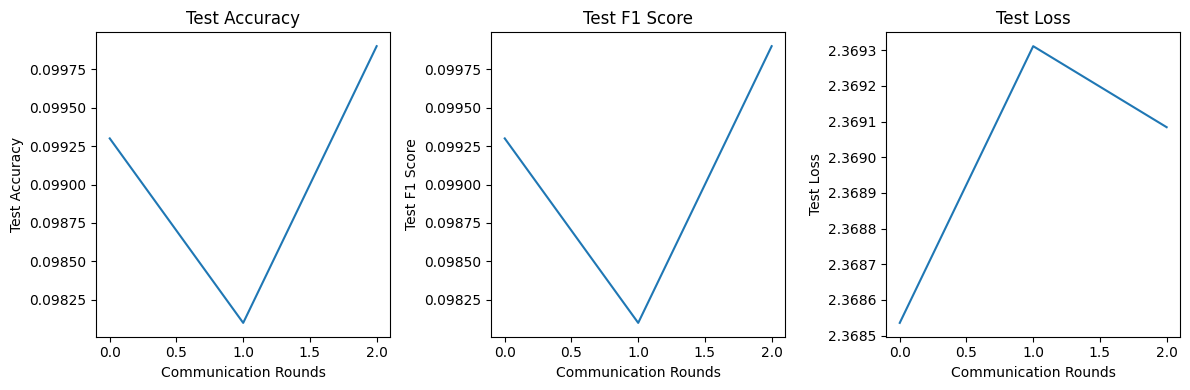

In [37]:



#show metrics

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(test_accuracies)
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy")

plt.subplot(1, 3, 2)
plt.plot(test_f1_scores)
plt.xlabel("Communication Rounds")
plt.ylabel("Test F1 Score")
plt.title("Test F1 Score")

plt.subplot(1, 3, 3)
plt.plot(test_losses)
plt.xlabel("Communication Rounds")
plt.ylabel("Test Loss")
plt.title("Test Loss")

plt.tight_layout()

plt.show()


### Tasks

1. Implement the FedAVG algorithm for federated learning. We do not want a version that uses a step size, i.e., a fixed number of SGD steps before averaging the models. Instead, we want a version that uses a fixed number of communication rounds. One communication round equals a local epoch on each client. We use `local_epoch` (also referred to as "round size") to denote the number of local epochs.
2. After each communication round, we want to evaluate the global model on the test set. After averaging the models, we evaluate the global model on the test set. We want to store the test loss, test accuracy, and test F1 score for each communication round and plot them at the end.
3. Use different values for `num_clients` and `local_epoch` and compare the results. What happens if you increase the number of clients? What happens if you increase the number of local epochs? Consider both the performance and training time.